In [903]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout , LSTM , Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [ ]:
def clean(col):
    if '(CIV)' in col:
        return col.split(' ')[0]
    else:
        return col

In [ ]:
def prepare_moisture_dataset():
    df_weather_moisture_sheet_one = pd.read_excel('../Weather Ivory Coast.xlsx' \
                                                  ,sheet_name='AgDash.CIV.SoilM.Download.20Yr'\
                                                  ,index_col=None)
    df_weather_moisture_sheet_two = pd.read_excel('../Weather Ivory Coast.xlsx'\
                                                  , sheet_name='AgDash.CIV.SoilM.Download.10Yr'\
                                                  ,index_col=None)
    df_moisture_20y = df_weather_moisture_sheet_one.append(df_weather_moisture_sheet_two)
    df_moisture_20y.reset_index(inplace=True)
    df_moisture_20y.drop(columns=['index'], inplace=True)
    df_moisture_20y.rename(columns={'Average Monthly Soil Moisture (mm in top 0-1.6m soil)':'Date'}\
                       , inplace=True)
    df_moisture_20y.rename(columns = lambda x:clean(x), inplace=True)
    df_moisture_20y['Date'] =  pd.to_datetime(df_moisture_20y['Date'], format='%d.%m.%Y')
    df_moisture_20y_filtered_regions = df_moisture_20y.iloc[:,[0,1,2,6,9,12,13,14]]
    df_moisture_20y_filtered_regions = df_moisture_20y_filtered_regions.set_index('Date')
    df_moisture_20y_filtered_regions['year'] = df_moisture_20y_filtered_regions.index.year
    df_moisture_20y_filtered_regions['month'] = df_moisture_20y_filtered_regions.index.month
    df_moisture_20y_filtered_regions['date'] = df_moisture_20y_filtered_regions.index.day
    
    return df_moisture_20y_filtered_regions

In [ ]:
def prepare_weather_dataset():
    
    df_weather_temp_precp_one = pd.read_excel('../Weather Ivory Coast.xlsx' \
                                                  ,sheet_name='AgDash.CIV.IvoryCoast.20Yr'\
                                                  ,index_col=None)
    df_weather_temp_precp_two = pd.read_excel('../Weather Ivory Coast.xlsx' \
                                                  ,sheet_name='AgDash.CIV.IvoryCoast.10Yr'\
                                                  ,index_col=None)
    df_weather_appended = df_weather_temp_precp_one.append(df_weather_temp_precp_two)
    df_weather_appended.rename(columns={'Unnamed: 0':'Variable','Unnamed: 1':'Date'}, inplace=True)
    df_weather_appended[df_weather_appended['Variable']=='Last updated:']
    df_weather_appended.drop(14600, inplace=True)
    df_weather_appended = df_weather_appended.iloc[:,[0,1,2,3,4,6,9,12,16]]

    df_weather_min_temp = df_weather_appended[df_weather_appended['Variable']=='Minimum Temperature (°C)']
    df_weather_min_temp.drop(columns='Variable', inplace=True)
    df_weather_min_temp.reset_index(inplace=True)
    df_weather_min_temp.drop(columns=['index'], inplace=True)
    df_weather_min_temp = df_weather_min_temp.set_index('Date')
    df_weather_min_temp.index =  pd.to_datetime(df_weather_min_temp.index, format='%d.%m.%Y')
    df_weather_min_temp['year'] = df_weather_min_temp.index.year
    df_weather_min_temp['month'] = df_weather_min_temp.index.month
    df_weather_min_temp['date'] = df_weather_min_temp.index.day
    df_weather_min_temp.rename(columns = lambda x:clean(x), inplace=True)

    df_weather_max_temp = df_weather_appended[df_weather_appended['Variable']=='Maximum Temperature (°C)']
    df_weather_max_temp.drop(columns='Variable', inplace=True)
    df_weather_max_temp.reset_index(inplace=True)
    df_weather_max_temp.drop(columns=['index'], inplace=True)
    df_weather_max_temp = df_weather_max_temp.set_index('Date')
    df_weather_max_temp.index =  pd.to_datetime(df_weather_max_temp.index, format='%d.%m.%Y')
    df_weather_max_temp['year'] = df_weather_max_temp.index.year
    df_weather_max_temp['month'] = df_weather_max_temp.index.month
    df_weather_max_temp['date'] = df_weather_max_temp.index.day
    df_weather_max_temp.rename(columns = lambda x:clean(x), inplace=True)

    df_weather_avg_temp = df_weather_appended[df_weather_appended['Variable']=='Average Temperature (°C)']
    df_weather_avg_temp.drop(columns='Variable', inplace=True)
    df_weather_avg_temp.reset_index(inplace=True)
    df_weather_avg_temp.drop(columns=['index'], inplace=True)
    df_weather_avg_temp = df_weather_avg_temp.set_index('Date')
    df_weather_avg_temp.index =  pd.to_datetime(df_weather_avg_temp.index, format='%d.%m.%Y')
    df_weather_avg_temp['year'] = df_weather_avg_temp.index.year
    df_weather_avg_temp['month'] = df_weather_avg_temp.index.month
    df_weather_avg_temp['date'] = df_weather_avg_temp.index.day
    df_weather_avg_temp.rename(columns = lambda x:clean(x), inplace=True)

    df_weather_precip = df_weather_appended[df_weather_appended['Variable']=='Precipitation (mm)']
    df_weather_precip.drop(columns='Variable', inplace=True)
    df_weather_precip.reset_index(inplace=True)
    df_weather_precip.drop(columns=['index'], inplace=True)
    df_weather_precip = df_weather_precip.set_index('Date')
    df_weather_precip.index =  pd.to_datetime(df_weather_precip.index, format='%d.%m.%Y')
    df_weather_precip['year'] = df_weather_precip.index.year
    df_weather_precip['month'] = df_weather_precip.index.month
    df_weather_precip['date'] = df_weather_precip.index.day
    df_weather_precip.rename(columns = lambda x:clean(x), inplace=True)
    
    return df_weather_min_temp, df_weather_max_temp, df_weather_avg_temp, df_weather_precip

In [ ]:
def prepare_close_dataset():
    df_20y_closing_price = pd.read_excel('../Cocoa Futures Prices.xlsx', sheet_name='Prices')
    df_20y_closing_price = df_20y_closing_price.iloc[:,[0,1]]
    df_20y_closing_price['Exchange Date'] = pd.to_datetime(df_20y_closing_price['Exchange Date'], format='%Y-%m-%d')
    df_20y_closing_price = df_20y_closing_price.set_index('Exchange Date')
    df_20y_closing_price['year'] = df_20y_closing_price.index.year
    df_20y_closing_price['date'] = df_20y_closing_price.index.day
    df_20y_closing_price['month'] = df_20y_closing_price.index.month
    return df_20y_closing_price

In [741]:
dataset_moisture = prepare_moisture_dataset()
dataset_minTemp, dataset_maxTemp, dataset_avgTemp, dataset_precip = prepare_weather_dataset()
dataset_close = prepare_close_dataset()

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# dataset_moisture.iloc[:,:-3].boxplot(figsize=(12,5), rot=90, grid=False, showmeans=True)
# plt.ylabel('Moisture(mm in top 0-1.6m soil)')
# plt.xlabel('Regions in Ivory Coast')
# np.round(pd.DataFrame(dataset_moisture.describe().iloc[[1,2,3,7],:-3]),2)#.to_csv('moistur_stats.csv')

In [ ]:
# dataset_minTemp.iloc[:,:-3].boxplot(figsize=(12,5), rot=90, grid=False, showmeans=True)
# plt.ylabel('Minimum Temperature')
# plt.xlabel('Regions in Ivory Coast')
# np.round(pd.DataFrame(dataset_minTemp.describe().iloc[[1,2,3,7],:-3]),2)

In [ ]:
# dataset_maxTemp.iloc[:,:-3].boxplot(figsize=(12,5), rot=90, grid=False, showmeans=True)
# plt.ylabel('Maximum Temperature')
# plt.xlabel('Regions in Ivory Coast')
# np.round(pd.DataFrame(dataset_maxTemp.describe().iloc[[1,2,3,7],:-3]),2)#.to_csv('moistur_stats.csv')

In [ ]:
# dataset_avgTemp.iloc[:,:-3].boxplot(figsize=(12,5), rot=90, grid=False, showmeans=True)
# plt.ylabel('Average Temperature')
# plt.xlabel('Regions in Ivory Coast')
# np.round(pd.DataFrame(dataset_avgTemp.describe().iloc[[1,2,3,7],:-3]),2)#.to_csv('moistur_stats.csv')

In [ ]:
# dataset_precip.iloc[:,:-3].boxplot(figsize=(12,5), rot=90, grid=False, showmeans=True)
# plt.ylabel('Precipitation')
# plt.xlabel('Regions in Ivory Coast')
# np.round(pd.DataFrame(dataset_precip.describe().iloc[[1,2,3,7],:-3]),2)#.to_csv('moistur_stats.csv')

In [ ]:
#https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [ ]:
# dataset_moisture.iloc[:,:-3].plot(figsize=(16,5)) #monthly
# dataset_minTemp.iloc[:,:-3].resample('M').median().plot(figsize=(16,5))
# dataset_maxTemp.iloc[:,:-3].resample('M').median().plot(figsize=(16,5))
# dataset_avgTemp.iloc[:,:-3].resample('M').median().plot(figsize=(16,5))
# dataset_precip.iloc[:,:-3].resample('M').median().plot(figsize=(16,5))

In [ ]:
# fig, ax = plt.subplots(figsize=(15,4))
# ax.plot(dataset_moisture['Cote D\'Ivoire'], marker='.', linestyle='-', linewidth=0.5, label='Daily')
# ax.plot(dataset_moisture['Cote D\'Ivoire'].resample("A").mean(), marker='+', markersize=8, linestyle='-.', label='Yearly Mean Resample')
# ax.set_ylabel(' Moisture')
# ax.set_xlabel('Date')
# ax.legend();

In [ ]:
# fig, ax = plt.subplots(figsize=(15,4))
# ax.plot(dataset_minTemp['Cote D\'Ivoire'], marker='.', linestyle='-', linewidth=0.5, label='Daily')
# ax.plot(dataset_minTemp['Cote D\'Ivoire'].resample("A").mean(), marker='+', markersize=8, linestyle='-.', label='Yearly Mean Resample')
# ax.set_ylabel(' Moisture')
# ax.set_xlabel('Date')
# ax.legend();

In [ ]:
# fig, ax = plt.subplots(figsize=(15,4))
# ax.plot(dataset_precip['Cote D\'Ivoire'], marker='.', linestyle='-', linewidth=0.5, label='Daily')
# ax.plot(dataset_precip['Cote D\'Ivoire'].resample("A").mean(), marker='+', markersize=8, linestyle='-.', label='Yearly Mean Resample')
# ax.set_ylabel(' Moisture')
# ax.set_xlabel('Date')
# ax.legend();

In [ ]:
# dataset_close.iloc[:,:-3].plot(figsize=(16,5))
# np.round(pd.DataFrame(dataset_close.describe().iloc[[1,2,3,7],:-3]),2)#.to_csv('moistur_stats.csv')

In [742]:
dataset_close = dataset_close['Close'].resample('MS').mean() # monthly start date resampled
dataset_close = pd.DataFrame(dataset_close, index=dataset_close.index)

In [743]:
dataset_moisture = dataset_moisture.iloc[:,[0]]
dataset_minTemp = dataset_minTemp.iloc[:,[0]]
dataset_maxTemp = dataset_maxTemp.iloc[:,[0]]
dataset_avgTemp = dataset_avgTemp.iloc[:,[0]]
dataset_precip = dataset_precip.iloc[:,[0]]
dataset_moisture.rename(columns={'Cote D\'Ivoire':'Moisture'}, inplace=True) # renaming column
dataset_minTemp.rename(columns={'Cote D\'Ivoire':'MinTemp'}, inplace=True) # renaming column
dataset_maxTemp.rename(columns={'Cote D\'Ivoire':'MaxTemp'}, inplace=True) # renaming column
dataset_avgTemp.rename(columns={'Cote D\'Ivoire':'AvgTemp'}, inplace=True) # renaming column
dataset_precip.rename(columns={'Cote D\'Ivoire':'Precip'}, inplace=True) # renaming column

In [744]:
# Merge using inner join on datetime index
df_prices_moisture = dataset_close.merge(dataset_moisture\
                                       , how='inner'\
                                       , left_index=True\
                                       , right_index=True
                           )
# Redefining index
df_prices_moisture.reset_index(inplace=True)
df_prices_moisture.set_index('index', inplace=True)

In [745]:
dataset_minTemp = dataset_minTemp.resample('MS').mean()
dataset_maxTemp = dataset_maxTemp.resample('MS').mean()
dataset_avgTemp = dataset_avgTemp.resample('MS').mean()
dataset_precip = dataset_precip.resample('MS').mean()

In [746]:
# Merge using inner join on datetime index
df_prices_moisture_mintemp = df_prices_moisture.merge(dataset_minTemp\
                                       , how='inner'\
                                       , left_index=True\
                                       , right_index=True
                           )

df_prices_moisture_mintemp.reset_index(inplace=True)
df_prices_moisture_mintemp.set_index('index', inplace=True)

In [747]:
# Merge using inner join on datetime index
df_prices_moisture_mintemp = df_prices_moisture.merge(dataset_minTemp\
                                       , how='inner'\
                                       , left_index=True\
                                       , right_index=True
                           )

df_prices_moisture_mintemp.reset_index(inplace=True)
df_prices_moisture_mintemp.set_index('index', inplace=True)

In [748]:
# Merge using inner join on datetime index
df_prices_moisture_mintemp_maxtemp = df_prices_moisture_mintemp.merge(dataset_maxTemp\
                                       , how='inner'\
                                       , left_index=True\
                                       , right_index=True
                           )

df_prices_moisture_mintemp_maxtemp.reset_index(inplace=True)
df_prices_moisture_mintemp_maxtemp.set_index('index', inplace=True)

In [749]:
# Merge using inner join on datetime index
df_prices_moisture_mintemp_maxtemp_avgtemp = df_prices_moisture_mintemp_maxtemp.merge(dataset_avgTemp\
                                       , how='inner'\
                                       , left_index=True\
                                       , right_index=True
                           )

df_prices_moisture_mintemp_maxtemp_avgtemp.reset_index(inplace=True)
df_prices_moisture_mintemp_maxtemp_avgtemp.set_index('index', inplace=True)

In [750]:
# Merge using inner join on datetime index
df_prices_moisture_mintemp_maxtemp_avgtemp_precip = df_prices_moisture_mintemp_maxtemp_avgtemp.merge(dataset_precip\
                                       , how='inner'\
                                       , left_index=True\
                                       , right_index=True
                           )

df_prices_moisture_mintemp_maxtemp_avgtemp_precip.reset_index(inplace=True)
df_prices_moisture_mintemp_maxtemp_avgtemp_precip.set_index('index', inplace=True)

In [751]:
df_IvoryCoast = df_prices_moisture_mintemp_maxtemp_avgtemp_precip.copy()

In [752]:
df_IvoryCoast['month'] = df_IvoryCoast.index.month
df_IvoryCoast['year'] = df_IvoryCoast.index.year

In [753]:
df_IvoryCoast.head()

,Close,Moisture,MinTemp,MaxTemp,AvgTemp,Precip,month,year
index,,,,,,,,
2000-03-01,579.150000,228.8,20.887097,38.854839,29.900000,1.819355,3,2000
2000-04-01,593.777778,234.7,23.123333,39.610000,31.393333,2.976667,4,2000
2000-05-01,613.095238,279.1,22.719355,37.777419,30.274194,4.583871,5,2000
2000-06-01,619.363636,349.0,21.613333,33.383333,27.530000,5.776667,6,2000
2000-07-01,610.857143,393.9,20.625806,31.245161,25.954839,4.064516,7,2000


In [ ]:
# #df['year'] = [d.year for d in df.date]
# #df['month'] = [d.strftime('%b') for d in df.date]
# years = df_IvoryCoast['year'].unique()

# # Prep Colors
# np.random.seed(100)
# mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# # Draw Plot
# plt.figure(figsize=(8,4), dpi= 100)
# for i, y in enumerate(years):
#     if i > 0:        
#         plt.plot('month', 'Precip', data=df_IvoryCoast.loc[df_IvoryCoast.year==y, :], color=mycolors[i], label=y)
#         plt.text(df_IvoryCoast.loc[df_IvoryCoast.year==y, :].shape[0], df_IvoryCoast.loc[df_IvoryCoast.year==y, 'Precip'][-1:].values[0], y, fontsize=8, color=mycolors[i])


In [ ]:
# #df['year'] = [d.year for d in df.date]
# #df['month'] = [d.strftime('%b') for d in df.date]
# years = df_IvoryCoast['year'].unique()

# # Prep Colors
# np.random.seed(100)
# mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# # Draw Plot
# plt.figure(figsize=(8,4), dpi= 100)
# for i, y in enumerate(years):
#     if i > 0:        
#         plt.plot('month', 'Close', data=df_IvoryCoast.loc[df_IvoryCoast.year==y, :], color=mycolors[i], label=y)
#         plt.text(df_IvoryCoast.loc[df_IvoryCoast.year==y, :].shape[0], df_IvoryCoast.loc[df_IvoryCoast.year==y, 'Close'][-1:].values[0], y, fontsize=8, color=mycolors[i])



In [ ]:
# decomposition_Close = sm.tsa.seasonal_decompose(df_IvoryCoast['Precip'], model='multiplicative')
# fig = decomposition_Close.plot()
# plt.show()

In [757]:
decomposition_Moisture = sm.tsa.seasonal_decompose(df_IvoryCoast['Moisture'], model='multiplicative')
decomposition_MinTemp = sm.tsa.seasonal_decompose(df_IvoryCoast['MinTemp'], model='multiplicative')
decomposition_MaxTemp = sm.tsa.seasonal_decompose(df_IvoryCoast['MaxTemp'], model='multiplicative')
decomposition_AvgTemp = sm.tsa.seasonal_decompose(df_IvoryCoast['AvgTemp'], model='multiplicative')
decomposition_Precip = sm.tsa.seasonal_decompose(df_IvoryCoast['Precip'], model='multiplicative')
decomposition_Close = sm.tsa.seasonal_decompose(df_IvoryCoast['Close'], model='multiplicative')

In [759]:
df_Ivory_residual = pd.concat([decomposition_Moisture.resid,decomposition_MinTemp.resid,decomposition_MaxTemp.resid,decomposition_AvgTemp.resid,decomposition_Precip.resid,decomposition_Close.resid],axis=1)
df_Ivory_residual.dropna(inplace=True)
df_Ivory_residual.index.name = 'Date'
df_Ivory_residual['month'] = df_Ivory_residual.index.month
df_Ivory_residual['year'] = df_Ivory_residual.index.year
df_Ivory_residual.head()

,Moisture,MinTemp,MaxTemp,AvgTemp,Precip,Close,month,year
Date,,,,,,,,
2000-09-01,1.007060,1.022139,1.023832,1.022186,1.009865,0.971364,9,2000
2000-10-01,1.004295,1.019263,1.006304,1.010330,0.984813,0.962382,10,2000
2000-11-01,1.024722,1.024002,0.991924,1.003785,1.253921,0.874749,11,2000
2000-12-01,1.034663,0.995086,0.991728,0.994344,0.546487,0.847439,12,2000
2001-01-01,1.021791,0.989449,0.988048,0.990362,0.134294,1.022057,1,2001


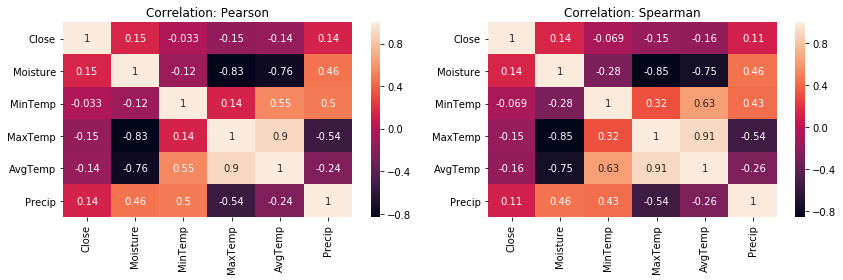

In [761]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].set(title='Correlation: Pearson')
axes[1].set(title='Correlation: Spearman')
#sns.heatmap(data=df_IvoryCoast.iloc[:,:-2].corr(method='pearson'), annot=True, ax=axes[0])
#sns.heatmap(data=df_IvoryCoast.iloc[:,:-2].corr(method='spearman'), annot=True, ax=axes[1])
sns.heatmap(data=df_IvoryCoast.iloc[:,:-2].corr(method='pearson'), annot=True, ax=axes[0])
sns.heatmap(data=df_IvoryCoast.iloc[:,:-2].corr(method='spearman'), annot=True, ax=axes[1])
plt.tight_layout()

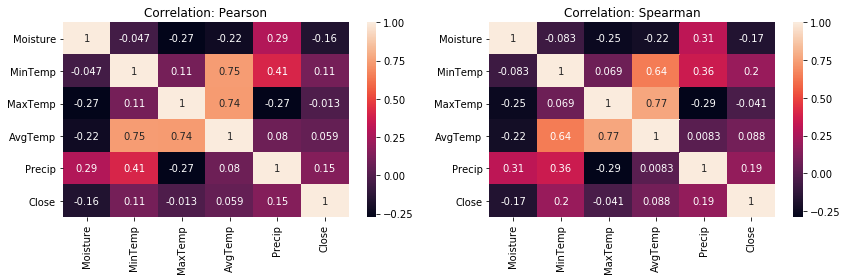

In [764]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].set(title='Correlation: Pearson')
axes[1].set(title='Correlation: Spearman')
#sns.heatmap(data=df_Ivory_residual.iloc[:,:-2].corr(method='pearson'), annot=True, ax=axes[0])
#sns.heatmap(data=df_Ivory_residual.iloc[:,:-2].corr(method='spearman'), annot=True, ax=axes[1])
sns.heatmap(data=df_Ivory_residual.iloc[:,:-2].corr(method='pearson'), annot=True, ax=axes[0])
sns.heatmap(data=df_Ivory_residual.iloc[:,:-2].corr(method='spearman'), annot=True, ax=axes[1])
plt.tight_layout()

In [ ]:
# # facet plot
# df_IvoryCoast.plot(subplots=True, 
#         linewidth=0.5,
# layout=(3, 2), figsize=(16, 10), sharex=False, sharey=False)

# plt.show()

In [ ]:
# # facet plot
# df_Ivory_residual.plot(subplots=True, 
#         linewidth=0.5,
# layout=(3, 2), figsize=(16, 10), sharex=False, sharey=False)

# plt.show()

In [766]:
# plt.figure(figsize=(20,5))
# plt.subplot(1,2,1)
# plt.subplots_adjust(wspace=0.2)
# sns.boxplot(x="year", y="Precip", data=df_Ivory_residual)
# plt.xlabel('year')
# plt.title('Box plot of Yearly MinTemp')
# sns.despine(left=True)
# plt.tight_layout()

# plt.figure(figsize=(20,5))
# plt.subplot(1,2,2)
# plt.subplots_adjust(wspace=0.2)
# sns.boxplot(x="year", y="Moisture", data=df_Ivory_residual)
# plt.xlabel('year')
# plt.title('Box plot of Yearly MinTemp')
# sns.despine(left=True)
# plt.tight_layout()

In [770]:
# #define function for ADF test
# def adf_test(timeseries):
#     #Perform Dickey-Fuller test:
#     print ('Results of Dickey-Fuller Test:')
#     '''
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)
#     '''
#     result = adfuller(timeseries, autolag='AIC')
#     print(f'ADF Statistic: {result[0]}')
#     print(f'p-value: {result[1]}')
#     for key, value in result[4].items():
#         print('Critial Values:')
#         print(f'   {key}, {value}')
#         if result[0]<value:
#             print('stationary')
#         else:
#             print('non-stationary')
#     if result[1]<0.05:
#         print('Stationary')
#     else:
#         print('Non-stationary')

In [771]:
# adf_test(df_Ivory_residual['Moisture'])
# adf_test(df_Ivory_residual['MinTemp'])
# adf_test(df_Ivory_residual['MaxTemp'])
# adf_test(df_Ivory_residual['AvgTemp'])
# adf_test(df_Ivory_residual['Precip'])

In [772]:
# adf_test(df_IvoryCoast['Moisture'])
# adf_test(df_IvoryCoast['MinTemp'])
# adf_test(df_IvoryCoast['MaxTemp'])
# adf_test(df_IvoryCoast['AvgTemp'])
# adf_test(df_IvoryCoast['Precip'])

In [ ]:
# #autocorrelation_plot(df_Ivory_residual['Moisture'])
# #autocorrelation_plot(df_IvoryCoast['Moisture'])
# plot_acf(df_IvoryCoast['Moisture'])
# plt.show()

In [773]:
# def get_rows(df):

#     if len(df.columns) % 2 == 0:
#         return len(df.columns)//2
#     else:
#         return (len(df.columns)//2) + 1

# def custom_autocorrelationplot(df):

#     no_of_rows = get_rows(df)
#     no_of_cols = 2

#     fig, axes = plt.subplots(no_of_rows, no_of_cols, figsize=(15, 15))
#     fig.subplots_adjust(hspace=1, top=0.4)

#     for col, ax in zip(list(df.columns), axes.flatten()):
#         pd.plotting.autocorrelation_plot(df[col], ax=ax)
#         ax.set_title(str(col))

# def custom_lagplot(df):

#     no_of_rows = get_rows(df)
#     no_of_cols = 2

#     fig, axes = plt.subplots(no_of_rows, no_of_cols, figsize=(15, 30))
#     fig.subplots_adjust(hspace=1, top=0.3)

#     for col, ax in zip(list(df.columns), axes.flatten()):
#         lag_plot(df[col], ax=ax)
#         ax.set_title(str(col))

In [ ]:
# custom_autocorrelationplot(df_Ivory_residual.iloc[:,:-2])

In [ ]:
# custom_lagplot(df_Ivory_residual.iloc[:,:-2])

In [774]:
df_Ivory_residual.drop(columns=['month','year'], inplace=True)

In [775]:
df_IvoryCoast.drop(columns=['month','year'], inplace=True)

In [1201]:
df_lagged = df_Ivory_residual.copy() #.iloc[:,1:]
trailing_window_size = 4

for window in range(1, trailing_window_size + 1):
    shifted = df_Ivory_residual.shift(window)
    shifted.columns = [x + "_lag_" + str(window) for x in df_Ivory_residual.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)

df_lagged = df_lagged.dropna()
#df_lagged.head()

In [1202]:
list_col = []
for col in df_lagged.columns.to_list():
    if 'Close_lag_' not in col:
        list_col.append(col)

#print(list_col)
list_col = list_col[:5]+list_col[6:]+[list_col[5]]
#print(list_col)
df_lagged = df_lagged[list_col]
#df_lagged

In [1203]:
'''
use only when .iloc[:,1:] is used in previous step where we dont use lag variable for close
df_lagged = df_lagged.merge(df_Ivory_residual.iloc[:,[0]]\
                                       , how='inner'\
                                       , left_index=True\
                                       , right_index=True
                           )
'''

"\nuse only when .iloc[:,1:] is used in previous step where we dont use lag variable for close\ndf_lagged = df_lagged.merge(df_Ivory_residual.iloc[:,[0]]                                       , how='inner'                                       , left_index=True                                       , right_index=True\n                           )\n"

In [1204]:
'''
cols = df_IvoryCoast.columns.to_list()
cols = cols[1:] + [cols[0]]
df_IvoryCoast = df_IvoryCoast[cols]
df_IvoryCoast.head()
'''

'\ncols = df_IvoryCoast.columns.to_list()\ncols = cols[1:] + [cols[0]]\ndf_IvoryCoast = df_IvoryCoast[cols]\ndf_IvoryCoast.head()\n'

In [1205]:
#df_lagged = df_lagged.iloc[:,6:] #shift,1 = 6 & shift,2 = 12 & shift,3 = 18
scaler = MinMaxScaler()
df_Ivory = scaler.fit_transform(df_lagged) #df_lagged #df_Ivory_residual(after decomp) #df_IvoryCoast(before decom)
y = df_Ivory[:,len(df_lagged.columns)-1]
X = df_Ivory[:,[i for i in range(0,len(df_lagged.columns)-1)]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [1206]:
# scaler = MinMaxScaler()
# df_Ivory = scaler.fit_transform(df_lagged)
# train_size = int(len(df_Ivory)*0.80)
# test_size = len(df_Ivory) - train_size
# train, test = df_Ivory[0:train_size,:], df_Ivory[train_size:len(df_Ivory),:]

# # convert an array of values into a dataset matrix
# def create_dataset(dataset, look_back=1):
#     X, Y = [], []
#     for i in range(len(dataset)-look_back-1):
#         a = dataset[i:(i+look_back), 0]
#         X.append(a)
#         Y.append(dataset[i + look_back, 0])
#     return np.array(X), np.array(Y)

# # reshape into X=t and Y=t+1
# look_back = 30
# X_train, y_train = create_dataset(train, look_back)
# X_test, y_test = create_dataset(test, look_back)
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

[0.02867425 0.11621895 0.03114252 0.03560299 0.03150342 0.10310378
 0.03064823 0.0359367  0.02723146 0.03024088 0.05645616 0.03017404
 0.03899077 0.02607942 0.02807188 0.03039341 0.03270261 0.03510276
 0.02798579 0.03777897 0.03793226 0.03224524 0.03202968 0.02650803
 0.05724579]


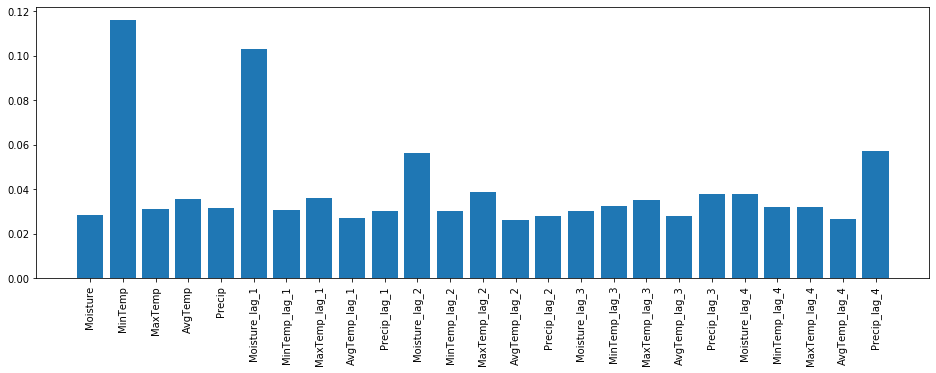

In [1207]:
#Variable importance
model_rfr = RandomForestRegressor(n_estimators=500, random_state=1)
model_rfr.fit(X, y)
print(model_rfr.feature_importances_)
names = df_lagged.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.figure(figsize=(16,5))
plt.bar(ticks, model_rfr.feature_importances_)
plt.xticks(ticks, names, rotation=90)
plt.show()

In [1208]:
# Variable Ranking
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=3)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = df_lagged.columns.values[0:-1]
list_selected = []
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])
        list_selected.append(names[i])

# #plot feature rank
# names = df_lagged.columns.values[0:-1]
# ticks = [i for i in range(len(names))]
# plt.bar(ticks, fit.ranking_)
# plt.xticks(ticks, names,rotation=90)
# plt.show()

Selected Features:
MinTemp
Moisture_lag_1
Precip_lag_4


In [1209]:
# Training on selected features
df_lagged_selected = df_lagged[list_selected]
df_lagged_selected = df_lagged_selected.merge(df_lagged['Close'],how='inner',left_index=True, right_index=True)
scaler = MinMaxScaler()
df_Ivory = scaler.fit_transform(df_lagged_selected) #df_lagged #df_Ivory_residual(after decomp) #df_IvoryCoast(before decom)
y = df_Ivory[:,len(df_lagged_selected.columns)-1]
X = df_Ivory[:,[i for i in range(0,len(df_lagged_selected.columns)-1)]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [1210]:
model = Sequential()
model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,verbose=2,callbacks=[EarlyStopping(patience=10)],shuffle=False)

#Training Phase
#model.summary()

Train on 177 samples, validate on 45 samples
Epoch 1/100
 - 5s - loss: 0.2571 - val_loss: 0.2353
Epoch 2/100
 - 0s - loss: 0.2331 - val_loss: 0.2119
Epoch 3/100
 - 0s - loss: 0.2108 - val_loss: 0.1904
Epoch 4/100
 - 0s - loss: 0.1902 - val_loss: 0.1706
Epoch 5/100
 - 0s - loss: 0.1714 - val_loss: 0.1526
Epoch 6/100
 - 0s - loss: 0.1541 - val_loss: 0.1362
Epoch 7/100
 - 0s - loss: 0.1384 - val_loss: 0.1213
Epoch 8/100
 - 0s - loss: 0.1242 - val_loss: 0.1079
Epoch 9/100
 - 0s - loss: 0.1113 - val_loss: 0.0960
Epoch 10/100
 - 0s - loss: 0.0998 - val_loss: 0.0854
Epoch 11/100
 - 0s - loss: 0.0896 - val_loss: 0.0761
Epoch 12/100
 - 0s - loss: 0.0806 - val_loss: 0.0680
Epoch 13/100
 - 0s - loss: 0.0727 - val_loss: 0.0611
Epoch 14/100
 - 0s - loss: 0.0660 - val_loss: 0.0552
Epoch 15/100
 - 0s - loss: 0.0602 - val_loss: 0.0504
Epoch 16/100
 - 0s - loss: 0.0555 - val_loss: 0.0465
Epoch 17/100
 - 0s - loss: 0.0516 - val_loss: 0.0435
Epoch 18/100
 - 0s - loss: 0.0484 - val_loss: 0.0411
Epoch 19/1

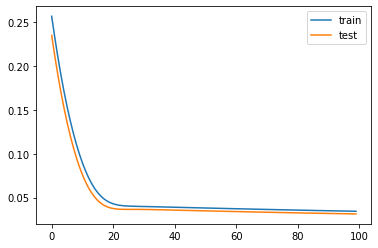

In [1211]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [1212]:
predicted = model.predict(X_test)
y_test = y_test.reshape(len(y_test),1)

In [991]:
y_test.shape

(68, 1)

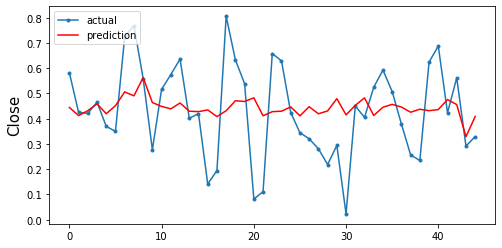

In [1215]:
aa=[x for x in range(y_test.shape[0])] #y_test.shape
plt.figure(figsize=(8,4))
plt.plot(aa, y_test, marker='.', label="actual")
plt.plot(aa, predicted, color='r', label="prediction")
plt.legend(loc="upper left")
plt.ylabel('Close', size=15)
plt.show();

In [897]:
X_test_Re = X_test.reshape(X_test.shape[0],X_test.shape[2])
predicted = np.concatenate((predicted,X_test_Re[:,1:]),axis=1)
y_test = np.concatenate((y_test,X_test_Re[:,1:]),axis=1)

In [1213]:
np.sqrt(mean_squared_error(y_test[:,0],predicted[:,0]))

0.17678577030729298

In [1214]:
np.sqrt(mean_absolute_error(y_test[:,0],predicted[:,0]))

0.3759443901323776

In [901]:
'''
result = pd.concat([pd.Series(predicted[:,0]),pd.Series(y_test[:,0])],axis=1)
result.columns = ['thetahat','theta']
result['diff'] = result['thetahat'] - result['theta']
'''

In [930]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

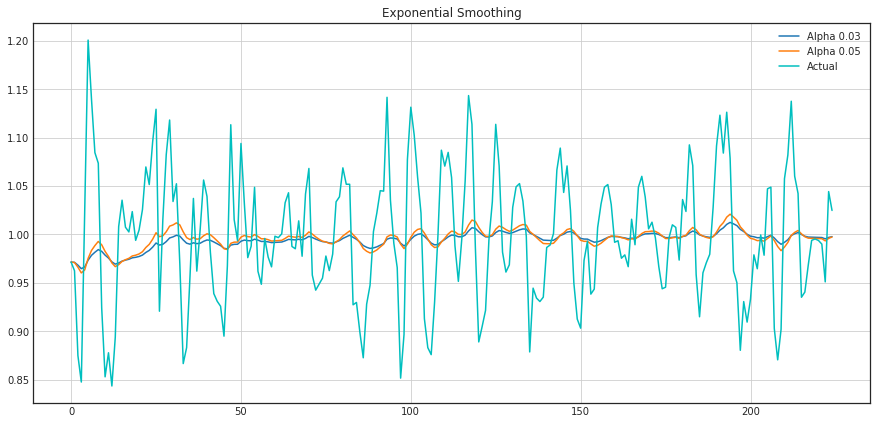

In [933]:
plotExponentialSmoothing(df_lagged['Close_lag1'],[0.03,0.05])